# Calculation of intra-mural peri-arterial drainage (IPAD) flow rate and volumetric flow rate

The model equation for flow through the BM is

$$
\frac{\partial}{\partial t} \left( R_i(z,t) \cdot h_{bm}(z,t) \right) = - \frac{\partial}{\partial z} \left( R_i(z,t) \cdot h_{bm}(z,t) \cdot q \right)
$$

with

$$
q = - K(p_z) p_z
$$

where $R_i(z,t)$ is the position of the BM, $h_{bm}(z,t)$ is the width of the BM, $K(p_z)$ is the pressure gradient dependent permeability of the BM and $p_z$ is the pressure gradient of the interstitial fluid (ISF) that runs through the BM [1,2].

Start by importing some useful libraries.

In [19]:
import numpy as np
import matplotlib.pylab as plt
from scipy.interpolate import interp2d

%matplotlib inline

plt.rcParams['axes.labelsize'] = 9
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = ['Arial']

WIDTH = 510
FACTOR = 1.0  # the fraction of the width you'd like the figure to occupy
fig_width_pt  = WIDTH * FACTOR
inches_per_pt = 1.0 / 72.27
golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
fig_width_in  = fig_width_pt * inches_per_pt  # figure width in inches
fig_height_in = fig_width_in * golden_ratio   # figure height in inches
fig_dims    = [fig_width_in, fig_height_in] # fig dims as a list
fig_dims_half = [fig_width_in, fig_height_in/2]

To calculate IPAD velocity we need to define a few parameters in relation to the geometry of the simulated arteriole. We will also define units and characteristic parameters such that the calculations are performed dimensionless.

In [30]:
# Units
cm = 1e-2
um = 1e-4 * cm
dyn = 1
pa = 10 * dyn/cm**2
s = 1

# Parameters
K = 1e-12 * cm**2 # permeability of the BM
M = 1.5e-3 * pa*s # viscosity of ISF
r0 = 20*um # arteriole radius
R = r0/r0 # dimensionless radius
w_ast = 10*um/r0 # width of astrocyte end-foot
gap = 1*um/r0 # gap between astrocyte end-feet
Le = 10*R + 5*w_ast + 4*gap # arteriole length
We = 0.2*R # arteriole wall thickness
Y = 1.0e6 * pa # Young's modulus
nu = 0.49 # Poisson's ratio
mu = Y/(2*(1+nu)) # Second Lame coefficient
Mu = mu/mu # Dimensionless Lame coefficient

## Flow rate

To calculate the flow rate $q$ we use

$$
q = - K(p_z) p_z
$$

which requires the pressure gradient of ISF $p_z = \partial p/\partial z$ from data. The data provides the radial stress component $\sigma_{rr}$, which is directly proportional to ISF pressure inside the BM

$$
p_z = -\sigma_{rr}
$$

All the following steps need to be carried out for each time step. Load the wall stress data into a Numpy array

In [21]:
Nx = 50 # number of points in radial direction
Ny = 500 # number of points in longitudinal direction
t = 0

srr = np.loadtxt("./ipad/rx5_5/stress.%s.csv" % (t), delimiter=',', 
                 skiprows=1)[:,0].reshape((Nx, Ny)).T # load wall stress data

Calculate ISF pressure inside the BM

In [22]:
Pbm = -srr

Define valve function of BM using $K_0$ and $K_1$

In [23]:
K0 = 0.1 * K/M
K1 = 1.0 * K/M

The wall stress data is already dimensionless, hence all other parameters and variables need to be nondimensionalised

In [24]:
K0 = K0 / r0**2 * mu
K1 = K1 / r0**2 * mu

Now calculate BM flow rate

In [25]:
def bm_flow(P, K0, K1, dx):
    U = np.copy(P)
    n = P.shape[0]
    for i in range(n):
        dp = np.gradient(P[i,:], dx)
        k = np.copy(dp)
        k[dp>=0] = K1 # apply pressure gradient dependent valve
        k[dp<0] = K0 # apply pressure gradient dependent valve
        U[i,:] = -k*dp
    return U

dx = Le/Pbm.shape[0]
Ubm = bm_flow(Pbm, K0, K1, dx) 
ipad = np.mean(Ubm, axis=1)

Plot the data for the current time step

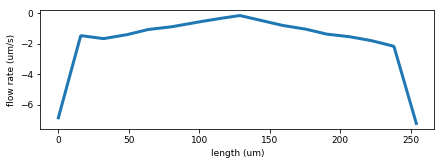

In [27]:
x = np.linspace(0, Le, Ny)
plt.figure(figsize=fig_dims_half)
plt.plot(x*r0/um, ipad*r0/(um/s), lw=3)
plt.xlabel("length (um)")
plt.ylabel("flow rate (um/s)")
plt.show()

## Volumetric flow rate

So far we have only used Darcy's law to calculate the 1D flow rate. But we are also interested in volumetric flow rate in order to determine how much ISF can be processed through the BM. To do that we will solve the model equation

$$
\frac{\partial}{\partial t} \left( R_i(z,t) \cdot h_{bm}(z,t) \right) = - \frac{\partial}{\partial z} \left( R_i(z,t) \cdot h_{bm}(z,t) \cdot q \right)
$$

using the Lax-Wendroff method for finite differences. This is the same method that is implemented in VaMpy. We require the flow rate for each time step (the code above shows the steps for one time step), which is loaded from a file

In [29]:
ipad = np.loadtxt("./ipad/ipad.csv", delimiter=',')/r0

We also require the displacement along the artery at the location of the BM, which was extracted from Paraview. From all data we discard the first and last 30 data points because the fixation of the displacement at the ends creates unnaturally large stresses, which we want to ignore in order to not overestimate IPAD 

In [39]:
Nt, Nx = ipad.shape
Ri = np.zeros((Nt, Nx))
for i in range(0, Nt):
    Ri[i,:] = np.loadtxt("./ipad/rx5_5/disp_line.%d.csv" % (i), delimiter=',',
                         skiprows=2)[30:-30,0]
Ri = Ri/r0 + 0.5*We # Ri is location (half way through the wall) plus displacement

We use the Lax Wendroff method to calculate $U = R_i \cdot h_{bm}$. Setting up initial conditions and parameters

In [40]:
def initial_conditions(Ri):
    U = Ri * (0.1*um) # assume BM at rest is 100 nm thick
    return U

U = initial_conditions(Ri)
u0 = U[0,:]
x = np.linspace(0, Le, 500)[30:-30]
y = np.linspace(0, tf, Nt)
dt = x[1] - x[0]
dx = y[1] - y[0]

Solve the conservation problem 

$$
\frac{\partial U}{\partial t} + \frac{\partial F}{\partial z} = S
$$

with $F = U \cdot q$, $S = 0$.

In [41]:
def F(U, ubm):
    return U*ubm
    
def S(U):
    return 0

def lax_wendroff(U_prev, F_prev, S_prev, u_bm, dt, dx):
    # u_prev = [U[m-1], U[m], U[m+1]], a_prev, p_prev analogously
    U_np_mp = (U_prev[2]+U_prev[1])/2 + dt/2 * (-(F_prev[2]-F_prev[1])/dx +\
                (S_prev[2]+S_prev[1])/2)
    U_np_mm = (U_prev[1]+U_prev[0])/2 + dt/2 * (-(F_prev[1]-F_prev[0])/dx +\
                (S_prev[1]+S_prev[0])/2)
    F_np_mp = F(U_np_mp, u_bm)
    F_np_mm = F(U_np_mm, u_bm)
    S_np_mp = S(U_np_mp)
    S_np_mm = S(U_np_mm)
    
    U_np = U_prev[1] - dt/dx * (F_np_mp-F_np_mm) + dt/2 * (S_np_mp+S_np_mm)
    return U_np

def numerical(U, ubm, time, dt, dx, x, L):
    for i in range(1,len(time)):
        v = (max(U[i-1,:])) # test cfl condition
        U[i,0] = U[0,0] # inlet boundary condition
        for j in range(1,len(x)-1):
            u_prev = U[i-1,j-1:j+2]
            f_prev = u_prev * ubm[i-1,j-1:j+2]
            s_prev = np.array([0,0,0])
            if len(u_prev) == 2: # at the end of the array
                u_prev = U[i-1,j-1:]
                f_prev = u_prev * ubm[i-1,j-1:]
                s_prev = np.array([0,0,0])
            U[i,j] = lax_wendroff(u_prev, f_prev, s_prev, ubm[i,j], dt, dx)                                                                    
        U[i,-1] = U[0,-1] # outlet boundary condition
    return U

U = numerical(U, ipad, y, dt, dx, x, Le)

Finally, we calculate the volumetric flow rate across the whole of the BM surrounding the arteriole

In [42]:
q = np.zeros((Nt, Nx))
for i in range(U.shape[0]):
    q[i,:] = 2 * np.pi * ipad[i,:] * U[i,:]

Plotting the result for time points 10, 50, 100, 200

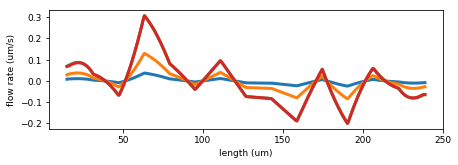

In [44]:
plt.figure(figsize=fig_dims_half)
plt.plot(x*r0/um, q[10,:]*r0**3/(um**3/s), lw=3)
plt.plot(x*r0/um, q[50,:]*r0**3/(um**3/s), lw=3)
plt.plot(x*r0/um, q[100,:]*r0**3/(um**3/s), lw=3)
plt.plot(x*r0/um, q[150,:]*r0**3/(um**3/s), lw=3)
plt.xlabel("length (um)")
plt.ylabel("flow rate (um/s)")
plt.show()

## References

[1] Diem AK, MacGregor Sharp M, Gatherer M, Bressloff NW, Carare RO and Richardson G (2017) Arterial Pulsations cannot Drive Intramural Periarterial Drainage: Significance for Aβ Drainage. Frontiers in Neuroscience 11:475. doi: https://doi.org/10.3389/fnins.2017.00475

[2] Diem AK, Carare RO, Weller RO, Bressloff NW (2017) A control mechanism for intramural periarterial drainage via astrocytes: How neuronal activity could improve waste clearance from the brain. arXiv preprint: https://arxiv.org/abs/1710.01117